In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

In [ ]:
data_set=pd.read_csv('train.csv')

In [ ]:
test_set=pd.read_csv('test.csv')

In [ ]:
labelencoder_X=LabelEncoder()

In [ ]:
def data_prep(train,test):
    all_data=pd.concat([train.drop('Survived',1),test])
    
    #Feature Title, Master, miss and other titles give us the indication that the person was young, other titles looks that the person was relativly old
    all_data['Title']=all_data['Name'].map(lambda complete_name: complete_name.split(',')[1].split('.')[0].strip())
    titles=set(all_data['Title'])
    temp_data=all_data[:len(train)]
    titles_mapping=dict(zip(titles,range(0,len(titles)+1)))
    temp_data['Numeric_title']=temp_data.apply(lambda passanger:titles_mapping[passanger.Title],axis=1).astype(int)
    all_data['Numeric_title']=all_data.apply(lambda passanger:titles_mapping[passanger.Title],axis=1).astype(int)
    #Fill unkonw embarcation with the mode of the embarked zone of the train data
    all_data.loc[all_data.Embarked.isnull(),'Embarked']=train.Embarked.mode()[0]
    #check why next line doesnt return int, instead return the letter
    #all_data['Embarket']=all_data['Embarked'].map({'C': 0, 'S': 1, 'Q': 2}).astype(int)
    all_data['Embarked']=labelencoder_X.fit_transform(all_data['Embarked'])
    embarket_place=sorted(all_data['Embarked'].unique(), key=lambda x: x)
    #Now let's fill missing age with the average of each title class but only using the train
    average_age_title={}
    for i in range(0,len(titles_mapping)):
        average_age_title[i]=np.median(train.loc[temp_data.Numeric_title==i,('Age')].dropna())
    all_data.loc[all_data.Age.isnull(),('Age')]=all_data[all_data.Age.isnull()].apply(lambda element: average_age_title.get(element.Numeric_title),axis=1)
    #From histogram people up to 10 have better prob to survive, for people with more than 63 is the opposite
    all_data['Young']=all_data.apply(lambda element: int(element.Age<=10),axis=1)
    all_data['Late_adulthood']=all_data.apply(lambda element: int(element.Age>=63),axis=1)
    #family size, non_including his/her-self
    all_data['Family_size']=all_data['SibSp']+all_data['Parch']
    #If the person is not-alone has better chances to survive
    all_data['Alone']=all_data.apply(lambda element: int((element.SibSp+element.Parch)==0),axis=1)
    #young+alone seem like has less probablity to live, but maybe is not so important since in the train only 1 is young and alone
    all_data['Young_alone']=all_data.apply(lambda element: (element.Young==1)and(element.Alone==1),axis=1).astype(int)
    #Also bigger families lower prob to survive :(
    all_data['Big_family']=all_data.apply(lambda element: (element.SibSp>2)or(element.Parch>3),axis=1).astype(int)
    #Obviuslly sex has a big impact, female has better prob to survive, there are sklearn ways to do this but pandas is really nice
    all_data['Sex']=all_data['Sex'].map({'male': 0, 'female': 1}).astype(int)
    #There is some correlation between fare and embarket place so let's use the mean/median (need to pay attention to the skwekness) for each embarket place
    # however let;s do this in future versions
    
    average_fare_class=np.zeros([3,3])
    #there are 3 classes so let's use it
    for i in range(1,4):
        for j in range(1,4):
            average_fare_class[i-1][j-1]=(np.nanmedian((train.Pclass==i)&(train.Embarked==j)))
    all_data.loc[all_data.Fare.isnull(),('Fare')]=all_data[all_data.Fare.isnull()].apply(lambda element: average_fare_class[element.Pclass-1][element.Embarked-1],axis=1)
    
    ##Number of roomates, roomates probably have the same fait, however I don't sure if this is OK for persons with a lot of cabins
    roomates=train.groupby(['Cabin'])['Survived'].sum()
    roomates_dic=dict(zip(roomates.index,roomates.values))
    all_data['Roomates']=all_data.apply(lambda element: (roomates_dic.get(element.Cabin)-1 if (roomates_dic.get(element.Cabin)>0) else roomates_dic.get(element.Cabin) ) if (str(element.Cabin)!='nan') else 0,axis=1)
    #need remove nan from cabin from the test then
    all_data.loc[all_data.Roomates.isnull(),('Roomates')]=0
    ##people with the same surename, however there are common surename so is not 100% perfect and can affect the prediction
    all_data['Surname']=all_data['Name'].map(lambda element: element.split(',')[0].strip())
    surename_list=sorted(all_data['Surname'].unique(), key=lambda x: x)
    all_data['Surname']=labelencoder_X.fit_transform(all_data['Surname'])

    return all_data[:len(train)],all_data[len(train):]
    
    
    
    

In [ ]:
train,test=data_prep(data_set,test_set)

In [ ]:
X_train=train.drop(['Ticket','Cabin','Name','Title','Surname'],axis=1)

In [ ]:
survived_train=data_set['Survived']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
standar_scaler=StandardScaler()


In [ ]:
X_train=standar_scaler.fit_transform(X_train)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
parameters_lasso={'C':np.logspace(-4,4,100),'penalty':['l1']}#these are c 
parameters_ridge={'alpha':np.logspace(-4,4,100)}# these are alpha
l1_ratio=np.logspace(-2,0,10)
parameters_elastic={'penalty':['elasticnet'],'alpha':np.logspace(-4,4,100),'l1_ratio':l1_ratio,'loss':['log']}

In [ ]:
clf_l1=LogisticRegression()
clf_l2=RidgeClassifier()
clf_elasti=SGDClassifier()

In [ ]:
kf=KFold(n_splits=3)

In [ ]:
grid_search_lasso=GridSearchCV(clf_l1,param_grid=parameters_lasso,cv=kf)
grid_search_ridge=GridSearchCV(clf_l2,param_grid=parameters_ridge,cv=kf)
grid_search_elasticnet=GridSearchCV(clf_elasti,param_grid=parameters_elastic,cv=kf)

In [ ]:
grid_search_lasso.fit(X_train,survived_train)

In [ ]:
grid_search_lasso.best_params_

In [ ]:
grid_search_lasso.best_params_.get('C')

In [ ]:
grid_search_lasso.best_score_

In [ ]:
grid_search_ridge.fit(X_train,survived_train)

In [ ]:
grid_search_ridge.best_params_

In [ ]:
grid_search_ridge.best_score_

In [ ]:
grid_search_elasticnet.fit(X_train,survived_train)

In [ ]:
grid_search_elasticnet.best_params_

In [ ]:
grid_search_elasticnet.best_score_

In [ ]:
clf_l1_new=LogisticRegression(C=grid_search_lasso.best_params_.get('C'),penalty=grid_search_lasso.best_params_.get('penalty'))
clf_l2_new=LogisticRegression(C=1.0/grid_search_ridge.best_params_.get('alpha'),penalty='l2')
clf_elasti_new=SGDClassifier(alpha=grid_search_elasticnet.best_params_.get('alpha'),l1_ratio=grid_search_elasticnet.best_params_.get('l1_ratio'),loss=grid_search_elasticnet.best_params_.get('loss'),penalty=grid_search_elasticnet.best_params_.get('penalty'))
clf_logistic_new=LogisticRegression(penalty='l2',C=10000000000)

In [ ]:
clf_l1_new.fit(X_train,survived_train)
clf_l2_new.fit(X_train,survived_train)
clf_elasti_new.fit(X_train,survived_train)
clf_logistic_new.fit(X_train,survived_train)

In [ ]:
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_train,survived_train , test_size=.2)


In [ ]:
survived_prediction_lasso=clf_l1_new.predict(X_train_roc)
survived_prediction_ridge=clf_l2_new.predict(X_train_roc)
survived_prediction_elasticnet=clf_elasti_new.predict(X_train_roc)
survived_prediction_logistic=clf_logistic_new.predict(X_train_roc)

In [ ]:
from sklearn.metrics import roc_curve,auc

In [ ]:
pfr_lasso, tpr_lasso, _= roc_curve(y_test_roc,clf_l1_new.predict_proba(X_test_roc)[:,1])
pfr_ridge, tpr_ridge, _= roc_curve(y_test_roc,clf_l2_new.predict_proba(X_test_roc)[:,1])
pfr_elasticnet, tpr_elasticnet, _= roc_curve(y_test_roc,clf_elasti_new.predict_proba(X_test_roc)[:,1])
pfr_logistic, tpr_logistic, _= roc_curve(y_test_roc,clf_logistic_new.predict_proba(X_test_roc)[:,1])

In [ ]:
#submission=pd.DataFrame({"PassengerID":test['PassengerId'],"Survived":survived_prediction})

In [ ]:
roc_auc_lasso=auc(pfr_lasso, tpr_lasso)
roc_auc_ridge=auc(pfr_ridge, tpr_ridge)
roc_auc_elasticnet=auc(pfr_elasticnet, tpr_elasticnet)
roc_auc_logistic=auc(pfr_logistic, tpr_logistic)

In [ ]:
#submission.to_csv('logistic_with_regularization.csv',index=False)

In [86]:
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(pfr_lasso,tpr_lasso,label='ROC Lasso (area=%0.2f)' % roc_auc_lasso,color='blue')
plt.plot(pfr_ridge,tpr_ridge,label='ROC Ridge (area=%0.2f)' % roc_auc_ridge,color='red')
plt.plot(pfr_elasticnet,tpr_elasticnet,label='ROC Elasticnet (area=%0.2f)' % roc_auc_elasticnet,color='green')
plt.plot(pfr_logistic,tpr_logistic,label='ROC Logistic (area=%0.2f)' % roc_auc_logistic,color='cyan')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

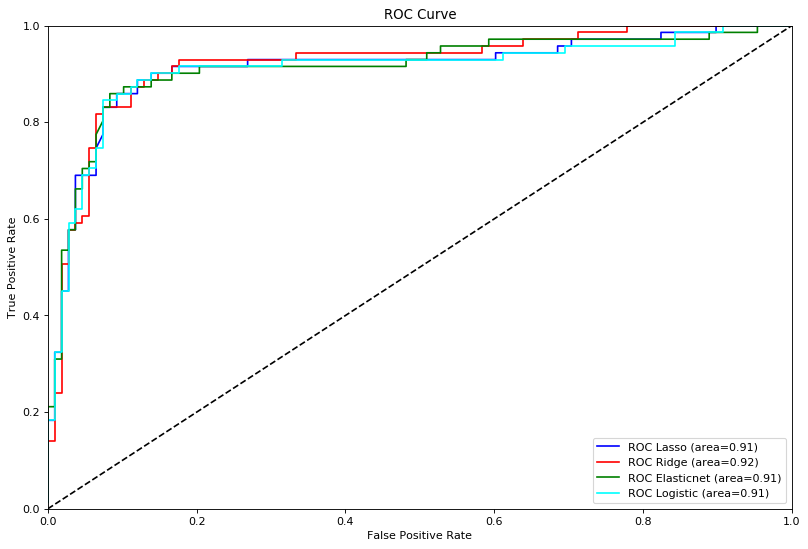

In [87]:
plt.show()